In [1]:
##### Decoding of stimulus identity (time-course)

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import import_ipynb
import func_analysis
import func_format

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from scipy import stats


importing Jupyter notebook from func_analysis.ipynb
importing Jupyter notebook from func_format.ipynb


In [4]:
#### train classifier on all ROC data during stimulus presentation period

ratID = ['Amygdala6', 'Amygdala8', 'Amygdala10', 'Amygdala11']
date = ['13042019', '01102019', '27062020', '06072020']

for r, rat in enumerate(ratID):

    responsetype = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
    #neuronlist = responsetype[np.where((responsetype[:,0] == rat))][:,2]
    neuronlist = responsetype[np.where((responsetype[:,0] == rat) & (responsetype[:,3] != 'unimodal'))][:,2]
    
    configpath = 'F:/'+rat+'/Parameters_'+date[r]+'.yml'
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)

    inttimes = np.loadtxt('F:/InteractionPresentation_synctimes.csv', delimiter = ',', dtype = str)
    inttimes = inttimes[np.where((inttimes[:,0] == rat) & (inttimes[:,1] == date[r]))]

    neuronpath = 'F:/'+rat+'/Electrophys/'+date[r]+'/SpikeTimes/Neurons_BLA/'
    #neuronlist = os.listdir('F:/'+rat+'/Electrophys/'+date[r]+'/SpikeTimes/Neurons_BLA/')


    #startstopint = np.array(np.vstack((inttimes[:,7], intsync_stop)), np.float).T
    startstopint = np.vstack((np.ravel(intsync_start), np.ravel(intsync_stop))).T
    startstopbase = np.vstack((np.ravel(intsync_start)-300, np.ravel(intsync_start))).T
    
    intnumber = startstopint.shape[0]
    neuronnumber = len(neuronlist)

    ROCresults = np.zeros((intnumber, neuronnumber))

    for n, neuron in enumerate(neuronlist):

        spikes = np.ravel(np.array(np.load(neuronpath+neuron+'.npy')/1000, np.float))


        for x, time in enumerate(startstopint):

            intspikes = func_analysis.extractSpikes(spikes, startstopint[x][0], startstopint[x][1])
            basespikes = func_analysis.extractSpikes(spikes, startstopbase[x][0], startstopbase[x][1])

            intfr = func_analysis.firingrate(intspikes, 1, startstopint[x][0], startstopint[x][1], smooth = False)
            basefr = func_analysis.firingrate(basespikes, 1, startstopbase[x][0], startstopbase[x][1], smooth=False)

            ROCresults[x, n] = func_analysis.calcROC(intfr, basefr)[0]

    ROCresults[np.isnan(ROCresults)] = 0.5

    trialid = np.empty([len(foldername)], np.int)
    labels = ['Male', 'Female', 'Object', 'Food']

    for i, label in enumerate(labels):
        trialid[np.where(np.ravel(intcat) == label)] = i+1

    ### Train basic model with data from one rat
    try:
        lda = LinearDiscriminantAnalysis()
        lda.fit(ROCresults, trialid)
    except:
        continue
        
    #### 5s moving intervals starting 150 seconds before interaction and ended 150s after, including 10s of data?
    alltimes = [0,0]
    timing = []
    prediction = []
    actualtrial = []
    trialname = []
    presentationnumber = []
    for x, time in enumerate(startstopint):
        startwindow = np.arange(time[0]-150, time[1]+150, 1)
        endwindow = startwindow+10

        times = np.vstack((startwindow, endwindow)).T

        for t, window in enumerate(times):

            auROCwindow = []

            for n, neuron in enumerate(neuronlist):
                spikes = np.ravel(np.array(np.load(neuronpath+neuron+'.npy')/1000, np.float))

                windowspikes = func_analysis.extractSpikes(spikes, window[0], window[1]+.01)
                windowfr = func_analysis.firingrate(windowspikes, 1, window[0], window[1]+.01, smooth=False)

                basespikes = func_analysis.extractSpikes(spikes, startstopbase[x][0], startstopbase[x][1])
                basefr = func_analysis.firingrate(basespikes, 1, startstopbase[x][0], startstopbase[x][1], smooth=False)

                auROCwindow = np.append(auROCwindow, func_analysis.calcROC(windowfr, basefr)[0])

            auROCwindow[np.isnan(auROCwindow)] = 0.5
            prediction = np.append(prediction, lda.predict(auROCwindow.reshape(1,-1)))
            actualtrial = np.append(actualtrial, trialid[x])
            trialname = np.append(trialname, foldername[x])
            presentationnumber = np.append(presentationnumber, presentationnum[x])

            alltimes = np.vstack((alltimes, window))

            if window[1] < startstopint[x][0]:
                timing = np.append(timing, 'before')
            elif (window[1] > startstopint[x][0]) & (window[1] < startstopint[x][1]):
                timing = np.append(timing, 'during')
            elif window[1] > startstopint[x][1]:
                timing = np.append(timing, 'after')
            else:
                timing = np.append(timing, 'nan')

    alltimes = alltimes[1:]
    alldata = np.vstack((alltimes[:,0], alltimes[:,1], prediction, timing, actualtrial, trialname, presentationnumber)).T
    
    np.savetxt('F:/Figure3_New/LDAovertime/'+rat+'_LDAresults_persecond_excludingunimodal.csv', alldata, delimiter = ',', fmt = '%s')
    print(rat+' completed')


Amygdala6 completed
Amygdala8 completed
Amygdala10 completed
Amygdala11 completed


In [304]:
A6results = np.loadtxt('F:/Amygdala6_LDAresults_persecond.csv', delimiter = ',', dtype = str)
A8results = np.loadtxt('F:/Amygdala8_LDAresults_persecond.csv', delimiter = ',', dtype = str)
A10results = np.loadtxt('F:/Amygdala10_LDAresults_persecond.csv', delimiter = ',', dtype = str)
A11results = np.loadtxt('F:/Amygdala11_LDAresults_persecond.csv', delimiter = ',', dtype = str)

In [356]:
Aresults[:,-2]

array(['2_int1', '2_int1', '2_int1', ..., '15_int14', '15_int14',
       '15_int14'], dtype='<U18')

In [425]:
resultsall = np.zeros(6)
allstartpredicted = np.zeros(120)
allstoppredicted = np.zeros(220)
allstartactual = np.zeros(120)
allstopactual = np.zeros(220)

resultsfiles = ['F:/Amygdala6_LDAresults_persecond_responsiveonly.csv',
               'F:/Amygdala8_LDAresults_persecond_responsiveonly.csv',
               'F:/Amygdala10_LDAresults_persecond_responsiveonly.csv',
               'F:/Amygdala11_LDAresults_persecond_responsiveonly.csv']
ratID = ['Amygdala6', 'Amygdala8', 'Amygdala10', 'Amygdala11']
date = ['13042019', '01102019', '27062020', '06072020']

for f, file in enumerate(resultsfiles):
    
    Aresults = np.loadtxt(file, delimiter = ',', dtype = str)


    for i, inte in enumerate(np.unique(Aresults[:,-2])):
        
        intresults = Aresults[Aresults[:,-2] == inte]
        
        before = Aresults[np.where((Aresults[:,-2] == inte) & (Aresults[:,3] == 'before') & (Aresults[:,-1] == '2.0'))]
        during = Aresults[np.where((Aresults[:,-2] == inte) & (Aresults[:,3] == 'during') & (Aresults[:,-1] == '2.0'))]
        after = Aresults[np.where((Aresults[:,-2] == inte) & (Aresults[:,3] == 'after') & (Aresults[:,-1] == '2.0'))]

        beforepredicted = np.array(before[:,2], float)
        beforeactual = np.array(before[:,4], float)

        duringpredicted = np.array(during[:,2], float)
        duringactual = np.array(during[:,4], float)

        afterpredicted = np.array(after[:,2], float)
        afteractual = np.array(after[:,4], float)
        
        start = intresults[80:200]
        stop = intresults[-220:]
        
        predictedstart = np.array(start[:,2], np.float)
        actualstart = np.array(start[:,4], np.float)
        
        predictedstop = np.array(stop[:,2], np.float)
        actualstop = np.array(stop[:,4], np.float)
        
        allstartpredicted = np.vstack((allstartpredicted, predictedstart))
        allstartactual = np.vstack((allstartactual, actualstart))
        
        allstoppredicted = np.vstack((allstoppredicted, predictedstop))
        allstopactual = np.vstack((allstopactual, actualstop))
        
        
        
        #TPbefore = np.count_nonzero(beforepredicted == beforeactual[0])/len(beforepredicted)
        #TPduring = np.count_nonzero(duringpredicted == duringactual[0])/len(duringpredicted)
        #TPafter = np.count_nonzero(afterpredicted == afteractual[0])/len(afterpredicted)
        
        results = np.hstack((inte, ratID[f], date[f], metrics.balanced_accuracy_score(beforeactual, beforepredicted), metrics.balanced_accuracy_score(duringactual, duringpredicted), metrics.balanced_accuracy_score(afteractual, afterpredicted)))

        resultsall = np.vstack((resultsall, results))
        #print(duringpredicted.shape)
        
        
resultsall = resultsall[1:]
allstartpredicted = allstartpredicted[1:]
allstartactual = allstartactual[1:]
allstoppredicted = allstoppredicted[1:]
allstopactual = allstopactual[1:]

    
    
    

C:\Users\Cristina\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Cristina\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Cristina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [428]:
resultsall

array([['11_int4', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['13_int5', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['14_int6', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['16_int7', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['18_int8', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['20_int9', 'Amygdala6', '13042019', '0.17857142857142858',
        '0.9172413793103448', '0.575'],
       ['22_int10', 'Amygdala6', '13042019', '0.2357142857142857',
        '0.8537414965986394', '0.2625'],
       ['24_int11', 'Amygdala6', '13042019', '0.2857142857142857',
        '0.9719626168224299', '0.81875'],
       ['26_int12', 'Amygdala6', '13042019', '0.1', '0.7703549060542797',
        '0.075'],
       ['28_int13', 'Amygdala6', '13042019', '0.4785714285714286',
        '0.989041095890411', '0.925'],
       ['2_int1', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['30_int14', 'Amygdala6', '13042019', '0.5142857142857142',
        '0.96934

In [426]:
resultsall

array([['11_int4', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['13_int5', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['14_int6', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['16_int7', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['18_int8', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['20_int9', 'Amygdala6', '13042019', '0.17857142857142858',
        '0.9172413793103448', '0.575'],
       ['22_int10', 'Amygdala6', '13042019', '0.2357142857142857',
        '0.8537414965986394', '0.2625'],
       ['24_int11', 'Amygdala6', '13042019', '0.2857142857142857',
        '0.9719626168224299', '0.81875'],
       ['26_int12', 'Amygdala6', '13042019', '0.1', '0.7703549060542797',
        '0.075'],
       ['28_int13', 'Amygdala6', '13042019', '0.4785714285714286',
        '0.989041095890411', '0.925'],
       ['2_int1', 'Amygdala6', '13042019', 'nan', 'nan', 'nan'],
       ['30_int14', 'Amygdala6', '13042019', '0.5142857142857142',
        '0.96934

In [419]:
A6actualstart = allstartactual[resultsall[:,1] == 'Amygdala6'].T
A6predictedstart = allstartpredicted[resultsall[:,1] == 'Amygdala6'].T

A6actualstop = allstopactual[resultsall[:,1] == 'Amygdala6'].T
A6predictedstop = allstoppredicted[resultsall[:,1] == 'Amygdala6'].T

A8actualstart = allstartactual[resultsall[:,1] == 'Amygdala8'].T
A8predictedstart = allstartpredicted[resultsall[:,1] == 'Amygdala8'].T

A8actualstop = allstopactual[resultsall[:,1] == 'Amygdala8'].T
A8predictedstop = allstoppredicted[resultsall[:,1] == 'Amygdala8'].T

A10actualstart = allstartactual[resultsall[:,1] == 'Amygdala10'].T
A10predictedstart = allstartpredicted[resultsall[:,1] == 'Amygdala10'].T

A10actualstop = allstopactual[resultsall[:,1] == 'Amygdala10'].T
A10predictedstop = allstoppredicted[resultsall[:,1] == 'Amygdala10'].T

A11actualstart = allstartactual[resultsall[:,1] == 'Amygdala11'].T
A11predictedstart = allstartpredicted[resultsall[:,1] == 'Amygdala11'].T

A11actualstop = allstopactual[resultsall[:,1] == 'Amygdala11'].T
A11predictedstop = allstoppredicted[resultsall[:,1] == 'Amygdala11'].T


In [420]:
A6balancedaccuracystart = []
A6balancedaccuracystop = []
for x, row in enumerate(A6actualstart):
    
    A6balancedaccuracystart = np.append(A6balancedaccuracystart, metrics.balanced_accuracy_score(row, A6predictedstart[x]))
    
for x, row in enumerate(A6actualstop):
    
    A6balancedaccuracystop = np.append(A6balancedaccuracystop, metrics.balanced_accuracy_score(row, A6predictedstop[x]))
    
A8balancedaccuracystart = []
A8balancedaccuracystop = []
for x, row in enumerate(A8actualstart):
    A8balancedaccuracystart = np.append(A8balancedaccuracystart, metrics.balanced_accuracy_score(row, A8predictedstart[x]))
for x, row in enumerate(A8actualstop):
    A8balancedaccuracystop = np.append(A8balancedaccuracystop, metrics.balanced_accuracy_score(row, A8predictedstop[x]))
    
A10balancedaccuracystart = []
A10balancedaccuracystop = []
for x, row in enumerate(A10actualstart):
    A10balancedaccuracystart = np.append(A10balancedaccuracystart, metrics.balanced_accuracy_score(row, A10predictedstart[x]))
for x, row in enumerate(A10actualstop):
    A10balancedaccuracystop = np.append(A10balancedaccuracystop, metrics.balanced_accuracy_score(row, A10predictedstop[x]))
    
A11balancedaccuracystart = []
A11balancedaccuracystop = []
for x, row in enumerate(A11actualstart):
    A11balancedaccuracystart = np.append(A11balancedaccuracystart, metrics.balanced_accuracy_score(row, A11predictedstart[x]))
for x, row in enumerate(A11actualstop):
    A11balancedaccuracystop = np.append(A11balancedaccuracystop, metrics.balanced_accuracy_score(row, A11predictedstop[x]))

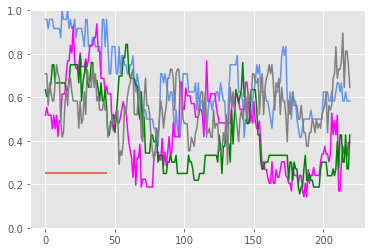

In [421]:
plt.plot(A6balancedaccuracystop, color = 'cornflowerblue')
plt.plot(A8balancedaccuracystop, color = 'magenta')
plt.plot(A10balancedaccuracystop, color = 'green')
plt.plot(A11balancedaccuracystop, color = 'grey')

plt.ylim(0,1)

plt.hlines(0.25, 0, 44)

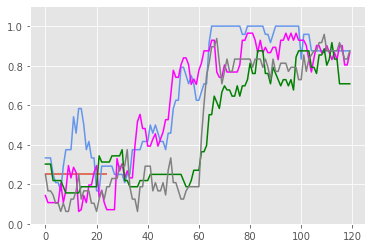

In [416]:
plt.plot(A6balancedaccuracystart, color = 'cornflowerblue')
plt.plot(A8balancedaccuracystart, color = 'magenta')
plt.plot(A10balancedaccuracystart, color = 'green')
plt.plot(A11balancedaccuracystart, color = 'grey')
plt.ylim(0,1.1)
plt.hlines(0.25, 0, 24)

{'whiskers': [<matplotlib.lines.Line2D at 0x159ef3f5850>,
 'caps': [<matplotlib.lines.Line2D at 0x159ef3f5f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x159ef3f54f0>,
 'medians': [<matplotlib.lines.Line2D at 0x159ef2dc610>,
 'fliers': [<matplotlib.lines.Line2D at 0x159ef2dc970>,
 'means': []}

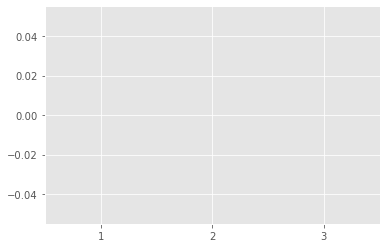

In [423]:
plt.boxplot((np.array(resultsall[:,-3], float), np.array(resultsall[:,-2], float), np.array(resultsall[:,-1], float)))
#plt.scatter(np.ones(len(during)), during)
#plt.scatter(np.full(len(after), 2), after)

<BarContainer object of 3 artists>

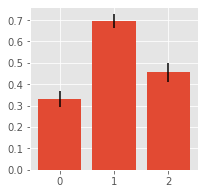

In [208]:
fig, ax = plt.subplots(1, figsize = (3, 3))

ax.bar((0,1,2), (np.mean(beforescore), np.mean(duringscore), np.mean(afterscore)), yerr = (stats.sem(beforescore), stats.sem(duringscore), stats.sem(afterscore)))




In [147]:
test = A6results[np.where((A6results[:,-1] == '2_int1') & (A6results[:,3] == 'before'))]

In [155]:
predicted = np.array(test[:,2], float)
actual = np.array(test[:,4], float)

In [160]:
metrics.balanced_accuracy_score(actual, predicted)

C:\Users\Cristina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.03571428571428571

In [157]:
actual

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [62]:
intnumber = startstopint.shape[0]
neuronnumber = len(neuronlist)

ROCresults = np.zeros((intnumber, neuronnumber))

for n, neuron in enumerate(neuronlist):
    
    spikes = np.ravel(np.array(np.load(neuronpath+neuron)/1000, np.float))
    
    
    for x, time in enumerate(startstopint):
        
        intspikes = func_analysis.extractSpikes(spikes, startstopint[x][0], startstopint[x][1])
        basespikes = func_analysis.extractSpikes(spikes, startstopbase[x][0], startstopbase[x][1])
        
        intfr = func_analysis.firingrate(intspikes, 1, startstopint[x][0], startstopint[x][1], smooth = False)
        basefr = func_analysis.firingrate(basespikes, 1, startstopbase[x][0], startstopbase[x][1], smooth=False)
        
        ROCresults[x, n] = func_analysis.calcROC(intfr, basefr)[0]
        

        
ROCresults[np.isnan(ROCresults)] = 0.5

trialid = np.empty([len(foldername)], np.int)
labels = ['Male', 'Female', 'Object', 'Food']

for i, label in enumerate(labels):
    trialid[np.where(np.ravel(intcat) == label)] = i+1

### Train basic model with data from one rat
lda = LinearDiscriminantAnalysis()
lda.fit(ROCresults, trialid)


In [106]:
#### 5s moving intervals starting 150 seconds before interaction and ended 150s after, including 10s of data?
alltimes = [0,0]
timing = []
prediction = []
actualtrial = []
for x, time in enumerate(startstopint):
    startwindow = np.arange(time[0]-150, time[1]+150, 5)
    endwindow = startwindow+10
    
    times = np.vstack((startwindow, endwindow)).T
    
    for t, window in enumerate(times):
        
        auROCwindow = []
        
        for n, neuron in enumerate(neuronlist):
            spikes = np.ravel(np.array(np.load(neuronpath+neuron)/1000, np.float))
            
            windowspikes = func_analysis.extractSpikes(spikes, window[0], window[1]+.01)
            windowfr = func_analysis.firingrate(windowspikes, 1, window[0], window[1]+.01, smooth=False)
        
            basespikes = func_analysis.extractSpikes(spikes, startstopbase[x][0], startstopbase[x][1])
            basefr = func_analysis.firingrate(basespikes, 1, startstopbase[x][0], startstopbase[x][1], smooth=False)
            
            auROCwindow = np.append(auROCwindow, func_analysis.calcROC(windowfr, basefr)[0])
        
        auROCwindow[np.isnan(auROCwindow)] = 0.5
        prediction = np.append(prediction, lda.predict(auROCwindow.reshape(1,-1)))
        actualtrial = np.append(actualtrial, trialid[x])
        
        alltimes = np.vstack((alltimes, window))
        
        if window[1] < startstopint[x][0]:
            timing = np.append(timing, 'before')
        elif (window[1] > startstopint[x][0]) & (window[1] < startstopint[x][1]):
            timing = np.append(timing, 'during')
        elif window[1] > startstopint[x][1]:
            timing = np.append(timing, 'after')
        else:
            timing = np.append(timing, 'nan')
        
alltimes = alltimes[1:]
alldata = np.vstack((alltimes[:,0], alltimes[:,1], prediction, timing, actualtrial[x])).T

In [121]:
timing[timing == 'nan']

array(['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan',
       'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan'], dtype='<U32')